Importing necessary libraries

In [1]:
import gizmo_analysis as gizmo
import utilities as ut
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import optimize
import math

Setting text properties for plots

In [2]:
plt.rcParams.update({'font.size': 16.5})
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
plt.close()

Constructing numerical PDF

Let $V$ be the set of values and $W$ be the set of corresponding weights, each having a size $n$. Further, let a scalar $\eta$ be called the norm. The normalization of the constructed PDF $g(z)$ is then -

$$\int_{-\infty}^{\infty} g(z) dz = \frac{1}{\eta} \sum_{i = 1}^{n} w_i$$

In [3]:
def num_PDF(values, weights, left, right, bin_size, norm):
    
    bins = np.arange(left, right, bin_size)
    heights, edges = np.histogram(values, bins, weights = weights)
    centers = 0.5*(edges[1:] + edges[:-1])
    heights = heights/(bin_size*norm)

    return centers, heights

Given a dataset $X, Y$ each having size $n$ and a fitting function $f$, we define our fit error measure as -

$$J = \sum_{i=1}^{n} (y_i - f(x_i))^2$$

In [4]:
def fit_error(y, f):
    return np.sum((y-f)**2)

Fitting function 1, Gaussian - 

$$ p(z)= \frac{A}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(z-\mu)^2}{2 \sigma^2}}$$

Which we want to obey the same normalization as the numerical PDF -

$$ \int_{-\infty}^{\infty} p(z) dz = \frac{1}{\eta} \sum_{i = 1}^{n} w_i$$

In [5]:
def fit_func_1(Z, A, mu, sigma):
    
    P = (A/np.sqrt(2*np.pi*sigma**2))*np.exp(-((Z-mu)**2/(2*sigma**2)))
    
    return P

Fitting function 2, normalized, piece-wise gaussian + power-law given by - 

$$ p(z)=  \left\{
\begin{array}{ll}
      \frac{A}{\sqrt{2 \pi \sigma^2}} e^{-\frac{(z-\mu)^2}{2 \sigma^2}} : z < z_T \\
      B e^{- \alpha z} : z \ge z_T \\
\end{array} 
\right. $$

Enforcing continuity at $z = z_T$ yields -

$$ B = \frac{Ae^{\alpha z_T}}{\sqrt{2 \pi \sigma^2}} e^{- \frac{(z_T - \mu)^2}{2 \sigma^2}} $$

Further, enforcing normalization identical to the numerical PDF, we get -

$$A = \frac{\frac{1}{\eta} \sum_{i = 1}^{n} w_i}{\frac{1}{2}\left( erf \left( \frac{z_T - \mu}{\sqrt{2} \sigma} \right) \right) + \frac{1}{\alpha \sqrt{2 \pi \sigma^2}} e^{- \frac{(z_T - \mu)^2}{2 \sigma^2}}} $$

Thus, the normalized PDF is -

$$ p(z)=  \frac{A}{\sqrt{2 \pi \sigma^2}} \left\{
\begin{array}{ll}
      e^{-\frac{(z-\mu)^2}{2 \sigma^2}} : z < z_T \\
      e^{-\frac{(z_T-\mu)^2}{2 \sigma^2}} \cdot e^{- \alpha(z-z_T)} : z \ge z_T \\
\end{array} 
\right. $$

Which obeys the same normalization as the numerical PDF -

$$ \int_{-\infty}^{\infty} p(z) dz = \frac{1}{\eta} \sum_{i = 1}^{n} w_i $$

In [6]:
def fit_func_2(Z, A, mu, sigma, alpha, z_T):
    
    B = (A*np.exp(alpha*z_T))/np.sqrt(2*np.pi*sigma**2)*np.exp(-(z_T-mu)**2/(2*sigma**2))
    
    Z_1 = Z[np.where(Z <= z_T)]
    Z_2 = Z[np.where(Z > z_T)]
    
    P_1 = (A/np.sqrt(2*np.pi*sigma**2))*np.exp(-((Z_1 - mu)**2/(2*sigma**2)))
    P_2 = B*np.exp(-alpha*Z_2)

    P = np.concatenate([P_1, P_2])
    
    return P

Constructing fitted PDF

In [7]:
def fit_PDF(centers, heights):
            
    fit = np.zeros(len(centers))
    fit_err = 0
    fit_params = np.zeros(5)

    # If all bins are empty
    if (np.all(heights == 0)):
        fit_params = np.array([0, float('nan'), float('nan'), float('nan'), float('nan')])
    
    # Otherwise
    else:
        
        # Information about the peak in the numerical PDF
        peak_ind = np.where(heights == np.max(heights))[0][0]
        peak_height = np.max(heights)
        
        # mu is where the numerical PDF peaks
        mu = centers[peak_ind]
        
        # Estimating sigma using FWHM
        sigma = 0
        
        for i in range(0, peak_ind):
            if(heights[i] >= peak_height/2):
                sigma = (mu - centers[i])/np.sqrt(2*np.log(2))
                break
          
        # Estimating A accordingly, by using the peak value at mu
        A = np.sqrt(2*np.pi*sigma**2)*peak_height
        
        # First fit a Gaussian
            
        guess_params = np.array([A, mu, sigma])
        fit_params, fit_covar = optimize.curve_fit(fit_func_1, centers, heights, p0=guess_params)
        fit = fit_func_1(centers, *fit_params)
        fit_err = fit_error(heights, fit)
        fit_params = np.concatenate([fit_params, np.array([float('nan'), float('nan')])])
                
        prev_err = fit_err
        
        # See if an exponential decay tail exists and is a better fit
        
        try:
        
            for i in range(peak_ind, len(centers)):
            
                v_T = centers[i] 
                init_height = heights[i]
            
                # Estimating alpha using half-life decay
                alpha = 0
        
                for j in range(i+1, len(centers)):
                    if(heights[j] <= init_height/2):
                        alpha = np.log(2)/(centers[j]-v_T)
                        break
            
                curr_guess_params = np.array([A, mu, sigma, alpha])
            
                curr_fit_params, curr_fit_covar = optimize.curve_fit(
                            lambda centers, A, mu, sigma, alpha: fit_func_2(centers, A, mu, sigma, alpha, v_T)
                                , centers, heights, p0=curr_guess_params, method = 'dogbox', maxfev = 5000)
            
                curr_fit = fit_func_2(centers, *curr_fit_params, v_T)
                curr_err = fit_error(heights, curr_fit)

                if(curr_err < prev_err):
                    fit = curr_fit
                    fit_err = curr_err
                    fit_params = np.concatenate([curr_fit_params, np.array([v_T])])
                
                prev_err = curr_err

        except:        
            pass
    
    return fit, fit_params

Importing dataset

In [8]:
# Specifying simulation directory and the directory to save results in
wdir = str(input('Enter simulation directory path: '))
sdir = wdir + str(input('Enter path of storage directory relative to simulation directory: '))

# Specifying snapshot index
sim_index = int(input('Enter snapshot index: '))

# Importing data from the snapshot
part = gizmo.io.Read.read_snapshots(['star', 'gas', 'dark'], 'index', sim_index, assign_hosts_rotation = True, 
                                    simulation_directory = wdir)

# Getting halo properties
halo_properties = ut.particle.get_halo_properties(part, 'all')

Enter simulation directory path: /Users/thepoetoftwilight/Documents/CASSI2020/CASSI2020-Data/m10q_res16000_test/
Enter path of storage directory relative to simulation directory: files/gauss_exp/
Enter snapshot index: 600

# in utilities.simulation.Snapshot():
* reading:  Users/thepoetoftwilight/Documents/CASSI2020/CASSI2020-Data/m10q_res16000_test/snapshot_times.txt

  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  Users/thepoetoftwilight/Documents/CASSI2020/CASSI2020-Data/m10q_res16000_test/output/snapshot_600.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 260408 particles
    dark2     (id = 2): 2281573 particles
    gas       (id = 0): 259203 particles
    star      (id = 4): 1205 particles
    blackhole (id = 5): 0 particles

* reading species: ['star', 'gas', 'dark']
* reading particles from:
    Users/thepoetoftwilight/Documents/CASSI2020/CASSI2020-Data/m10q_res16000_test/output/sna

In [9]:
# Creating the fit_info file

info = open(sdir + 'fit_info.txt', 'w')
info.write('Fit Information \n \n')
info.close()

Obtaining key properties of the galaxy

In [10]:
# Virial radius

r_vir = halo_properties['radius']

# Finding radial distance, temperature, number density, and mass of grid cells

radii = part['gas'].prop('host.distance.principal.spherical')[:,0]
temperatures = part['gas'].prop('temperature')
number_densities = part['gas'].prop('number.density')
masses = part['gas'].prop('mass')

Defining the ISM and its phases

In [11]:
# Create a dictionary linking phases to numbers

phases = {0: 'ISM', 1: 'HIM', 2: 'WIM', 3: 'WNM', 4: 'CNM'}
num_phases = len(phases)

In [12]:
# Defining the ISM and its phases

select_phases = []

# ISM
select_phases.append(radii < 0.1*r_vir)

# HIM
select_phases.append(np.all([(radii < 0.1*r_vir), (temperatures >= 10**5.5)], axis = 0))

# WIM
select_phases.append(np.all([(radii < 0.1*r_vir), (temperatures >= 10**4), (temperatures < 10**5.5)], axis = 0))

# WNM
select_phases.append(np.all([(radii < 0.1*r_vir), (temperatures >= 10**3), (temperatures < 10**4)], axis = 0))

# CNM
select_phases.append(np.all([(radii < 0.1*r_vir), (temperatures < 10**3)], axis = 0))

Choosing metals and pre-processing abundances

In [13]:
# Defining metals of interest

metals = ['c','n','o','ne','mg','si','s','ca','fe']

# Writing this list to fit_info.txt

info = open(sdir + 'fit_info.txt', 'a')

info.write('Elements \n \n')

info.write('[')
for i in range(0, len(metals)):
    if(i < len(metals)-1):
        info.write(metals[i] + ',')
    else:
        info.write(metals[i] + ']')
        
info.write('\n \n')

info.close()

In [14]:
# Finding the mass and abundance of metals in the ISM as well as its various phases by grid cells

# Grid distribution of masses by phase

mass_phases = []

for i in range(0, num_phases):
    mass_phases.append(masses[select_phases[i]])

# Grid distribution of abundances by phase

abundance_metals_phases = {}

for m in metals:
    abundance_metals_phases[m] = []
    for i in range(0, num_phases):
        abundance_metals_phases[m].append(part['gas'].prop('metallicity.' + m)[select_phases[i]])

Generating numerical PDF and its Gaussian + exp. decay fit. We want the numerical PDFs to be normalized to tbe mass of the concerned phase. But due to overflow concerns, we'll first normalize to the PDFs to the mass fraction of the ISM occupied by the concerned phase, and then rescale it to the mass of the phases itself.

In [15]:
# Label and color arrays for later plots

labels_raw = ['ISM raw', 'HIM raw', 'WIM raw', 'WNM raw', 'CNM raw']
labels_fit = ['ISM fit', 'HIM fit', 'WIM fit', 'WNM fit', 'CNM fit']
colors = ['blue', 'orange', 'brown', 'green', 'black']

# Common bin-size for all numerical PDFs

bin_size = 0.05

Completed rendering numerical and fitted PDFs, writing fit parameters to fit_info.txt for C
Completed rendering numerical and fitted PDFs, writing fit parameters to fit_info.txt for N
Completed rendering numerical and fitted PDFs, writing fit parameters to fit_info.txt for O
Completed rendering numerical and fitted PDFs, writing fit parameters to fit_info.txt for Ne
Completed rendering numerical and fitted PDFs, writing fit parameters to fit_info.txt for Mg
Completed rendering numerical and fitted PDFs, writing fit parameters to fit_info.txt for Si
Completed rendering numerical and fitted PDFs, writing fit parameters to fit_info.txt for S
Completed rendering numerical and fitted PDFs, writing fit parameters to fit_info.txt for Ca
Completed rendering numerical and fitted PDFs, writing fit parameters to fit_info.txt for Fe


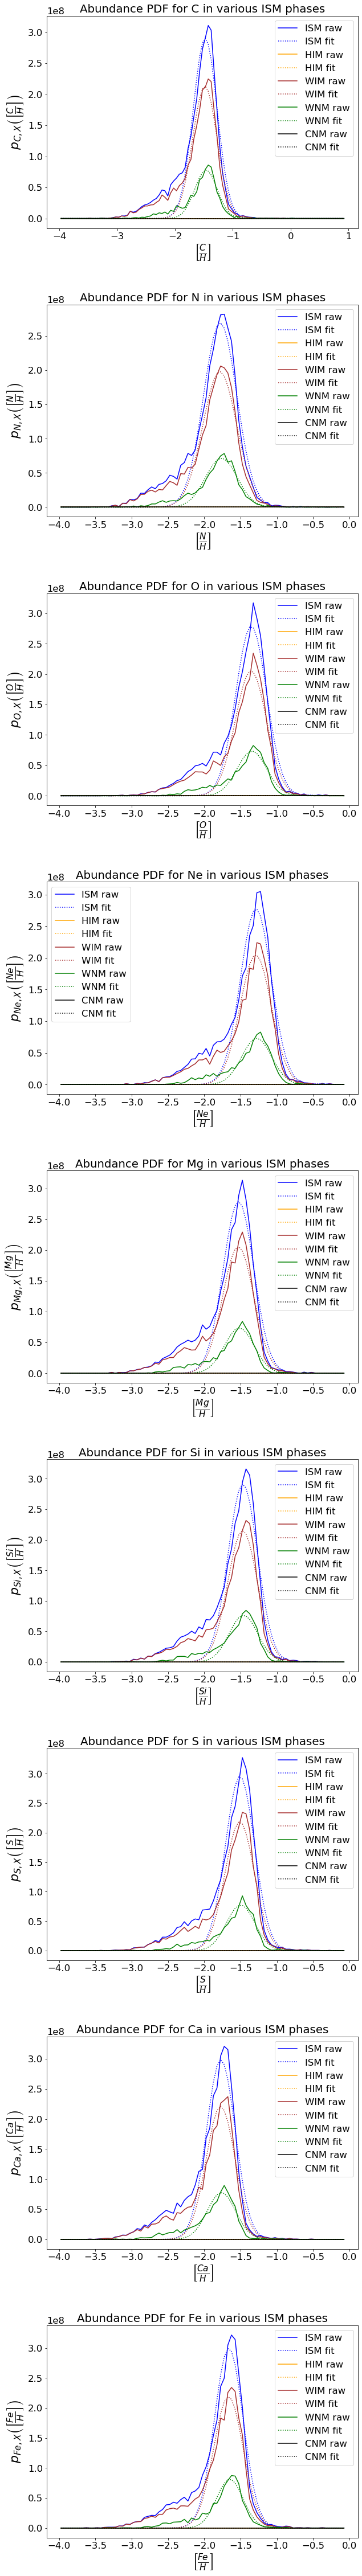

In [16]:
# Generating numerical PDFs and Gaussian + exp decay fits, also writing fit parameters to fit_info.txt

info = open(sdir + 'fit_info.txt','a')

info.write('Info array can be of the following forms \n \n') 
info.write('1. Empty phase - [0, nan, nan, nan, nan] \n')
info.write('2. Pure Gaussian - [A, mu, sigma, nan, nan] \n')
info.write('3. Gaussian + exp. decay - [A, mu, sigma, alpha, z_T] \n \n')

mass_norm = np.sum(mass_phases[0])

fig, axes = plt.subplots(nrows = len(metals), ncols = 1, figsize = (10, 64))

for k in range(0, len(metals)):
    
    ax = axes[k]
    m = metals[k]
    
    info.write(m + '\n \n')

    # Creating bins

    left = np.floor(np.min(abundance_metals_phases[m][0]))
    right = np.ceil(np.max(abundance_metals_phases[m][0]))

    for i in range(0, len(phases)):
    
        # Compute the numerical PDF
        
        centers, heights = num_PDF(abundance_metals_phases[m][i], mass_phases[i], 
                                   left, right, bin_size, mass_norm)
        
        # Compute the fitted PDF
        
        fit, fit_params = fit_PDF(centers, heights)
        
        # Rescaling heights to achieve desired normalization
        
        heights *= mass_norm
        fit *= mass_norm
        fit_params[0] *= mass_norm
        
        # Plotting the raw data and the fit
       
        ax.plot(centers, heights, color = colors[i], label = labels_raw[i])
        ax.plot(centers, fit, color = colors[i], label = labels_fit[i], linestyle = ':')
        
        # Writing fit parameters into fit_info.txt
        
        info.write(phases[i] + ': [')
        
        for j in range(0, len(fit_params)):
            if(j < len(fit_params)-1):
                info.write(str(fit_params[j]) + ',')
            else:
                info.write(str(fit_params[j]) + ']')
        
        info.write('\n')

    # Labelling the plots
    
    ax.set_xlabel(r'$\left[ \frac{{{}}}{{H}} \right]$'.format(m.title()), fontsize = 22)
    ax.set_ylabel(r'$p_{{{0}, X}} \left( \left[ \frac{{{0}}}{{H}} \right] \right)$'.format(m.title()),
                 fontsize = 22)
    ax.set_title('Abundance PDF for {} in various ISM phases'.format(m.title()))
    ax.legend()
    
    # Saving the plots
    fig.tight_layout(pad = 3.0)
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(sdir + 'abundance_{}.png'.format(m.title()), bbox_inches=extent.expanded(1.35, 1.35))
    
    info.write('\n \n')
    
    print('Completed rendering numerical and fitted PDFs, writing fit parameters to fit_info.txt for {}'.format(m.title()))
    
info.close()